In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
band_labels = ["Delta (1–4 Hz)", "Theta (4–8 Hz)",
               "Alpha (8–12 Hz)", "Beta (12–30 Hz)"]


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ---- directory for bandpower plots (inside your OUTDIR2) ----
BP_OUTDIR = os.path.join(OUTDIR2, "bandpower_evolution")
os.makedirs(BP_OUTDIR, exist_ok=True)

# band labels (same order as in your `bands` dict)
band_labels = ["Delta (1–4 Hz)", "Theta (4–8 Hz)",
               "Alpha (8–12 Hz)", "Beta (12–30 Hz)"]

def plot_bandpower_evolution_for_sample(X_features,
                                        sample_idx,
                                        window_indices,
                                        band_idx,
                                        height=8,
                                        width=8,
                                        band_labels=None,
                                        filename_prefix="msfusionnet"):
    """
    Visualise bandpower as 8×8 spatial maps over several time windows,
    similar to your PLV temporal evolution plot.

    X_features:   (num_samples, num_windows, height*width*num_bands)
    sample_idx:   which trial/sample to visualise
    window_indices: list of window indices, e.g. [0, 1, 2]
    band_idx:     which band to show (0:delta, 1:theta, 2:alpha, 3:beta)
    """
    num_bands = int(X_features.shape[-1] // (height * width))
    if band_labels is None:
        band_labels = [f"Band {i}" for i in range(num_bands)]

    n_seg = len(window_indices)
    plt.figure(figsize=(5 * n_seg, 5))

    # global min/max for consistent colour scale
    # (only this band, across the chosen windows)
    all_maps = []
    for w in window_indices:
        vec = X_features[sample_idx, w, :]
        cube = vec.reshape(height, width, num_bands)    # (8, 8, 4)
        all_maps.append(cube[:, :, band_idx])
    vmin = np.min(all_maps)
    vmax = np.max(all_maps)

    for i, w in enumerate(window_indices):
        plt.subplot(1, n_seg, i + 1)
        vec = X_features[sample_idx, w, :]
        cube = vec.reshape(height, width, num_bands)    # (8, 8, 4)
        band_map = cube[:, :, band_idx]                 # (8, 8) for one band

        sns.heatmap(band_map,
                    cmap="viridis",
                    vmin=vmin, vmax=vmax,
                    square=True,
                    cbar=(i == n_seg - 1))  # show one colorbar on last panel
        plt.title(f"Window {w}")
        plt.axis("off")

    plt.suptitle(f"Temporal Evolution of Bandpower – {band_labels[band_idx]}",
                 y=0.92)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)

    fname = f"{filename_prefix}_sample{sample_idx}_band{band_idx}.png"
    save_path = os.path.join(BP_OUTDIR, fname)
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()
    print(f"Saved plot: {save_path}")


NameError: name 'OUTDIR2' is not defined

In [5]:
import os
import pandas as pd

data_path = '/kaggle/input/datasetttt'
files = os.listdir(data_path)
print("Files in dataset directory:", files)

# Load each CSV file (adjust extension if needed)
dfs = {}
for file in files:
    if file.endswith('.csv'):
        dfs[file] = pd.read_csv(os.path.join(data_path, file))
        print(f"\nLoaded {file} with shape: {dfs[file].shape}")

Files in dataset directory: ['combined_data_new2.dat']


In [6]:
for file, df in dfs.items():
    print(f"\nInfo for {file}:")
    print(df.info())
    print(f"\nMissing values in {file}:")
    print(df.isnull().sum())
    print(f"\nSample data from {file}:")
    print(df.head())

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

for file, df in dfs.items():
    print(f"\nSummary statistics for {file}:")
    print(df.describe())
    
    numeric_cols = df.select_dtypes(include=['number']).columns
    if len(numeric_cols) == 0:
        print(f"No numeric columns found in {file} for histogram plotting.")
        continue
    
    df[numeric_cols].hist(figsize=(12, 8))
    plt.suptitle(f'Distributions in {file}')
    plt.show()

In [8]:
for file, df in dfs.items():
    print(f"\nData types in {file}:")
    print(df.dtypes)

In [9]:
for file, df in dfs.items():
    # Try to convert all columns to numeric where possible
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='ignore')
    print(f"After conversion, dtypes for {file}:")
    print(df.dtypes)

In [11]:
import numpy as np
import pickle

# Load dataset (pickle .dat file with keys 'data' and 'labels')
file_path = '/kaggle/input/datasetttt/combined_data_new2.dat'
with open(file_path, 'rb') as f:
    data_dict = pickle.load(f)

data = data_dict['data']      # shape: (num_samples, num_channels, num_timepoints)
labels = data_dict['labels']  # shape: (num_samples,)

num_samples, num_channels, num_timepoints = data.shape

# Parameters for temporal segmentation
sampling_freq = 128        # Hz, adjust if needed
segment_seconds = 1        # segment length in seconds
segment_length = sampling_freq * segment_seconds  # number of time points per segment
step_length = segment_length   # non-overlapping segments; you can reduce for overlap

num_segments_per_sample = (num_timepoints - segment_length) // step_length + 1
total_segments = num_samples * num_segments_per_sample

print(f"Total segments expected: {total_segments}")

# 8x8 spatial mapping for 64 channels (row, col) in grid
# Fill row-wise (0,0) to (7,7) for channels 0-63
channel_map_8x8 = -1 * np.ones((8, 8), dtype=int)
chan_idx = 0
for r in range(8):
    for c in range(8):
        if chan_idx < num_channels:
            channel_map_8x8[r, c] = chan_idx
            chan_idx += 1

# Initialize arrays for spatial EEG data and labels
eeg_spatial_8x8 = np.zeros((total_segments, 8, 8, segment_length))
eeg_labels = np.zeros(total_segments, dtype=labels.dtype)

seg_idx = 0
for sample_idx in range(num_samples):
    for seg_start in range(0, num_timepoints - segment_length + 1, step_length):
        seg_end = seg_start + segment_length
        seg_matrix = np.zeros((8, 8, segment_length))
        for r in range(8):
            for c in range(8):
                ch = channel_map_8x8[r, c]
                if ch >= 0:
                    seg_matrix[r, c, :] = data[sample_idx, ch, seg_start:seg_end]
        eeg_spatial_8x8[seg_idx] = seg_matrix
        eeg_labels[seg_idx] = labels[sample_idx]
        seg_idx += 1

print(f"Segments created: {seg_idx}")

# Save spatial EEG segments and corresponding labels
np.save('eeg_spatial_8x8.npy', eeg_spatial_8x8[:seg_idx])
np.save('labels.npy', eeg_labels[:seg_idx])

print('Saved eeg_spatial_8x8.npy and labels.npy')
print('eeg_spatial_8x8 shape:', eeg_spatial_8x8[:seg_idx].shape)
print('labels shape:', eeg_labels[:seg_idx].shape)

Total segments expected: 1896
Segments created: 1896
Saved eeg_spatial_8x8.npy and labels.npy
eeg_spatial_8x8 shape: (1896, 8, 8, 128)
labels shape: (1896,)


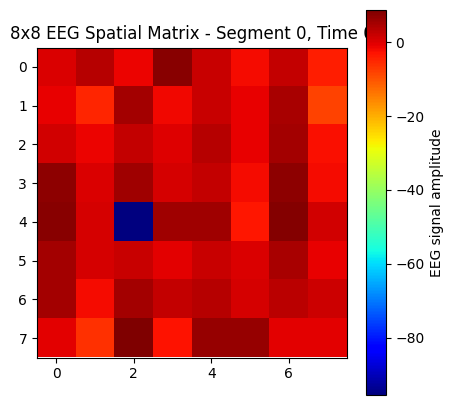

In [12]:
import matplotlib.pyplot as plt

# Load the saved spatial EEG data if needed
eeg_spatial_8x8 = np.load('eeg_spatial_8x8.npy')  # shape: (total_segments, 8, 8, segment_length)

# Select a segment and time index to visualize
segment_idx = 0    # pick the first segment or change as needed
time_idx = 0       # pick the first time point in the segment or change

# Extract the 8x8 spatial matrix at the selected time point within the segment
spatial_matrix = eeg_spatial_8x8[segment_idx, :, :, time_idx]

# Display the matrix with a colorbar
plt.figure(figsize=(5, 5))
plt.imshow(spatial_matrix, cmap='jet', interpolation='nearest')
plt.colorbar(label='EEG signal amplitude')
plt.title(f'8x8 EEG Spatial Matrix - Segment {segment_idx}, Time {time_idx}')
plt.show()

2025-11-25 16:06:43.359492: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764086803.521164      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764086803.566656      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

I0000 00:00:1764087124.803063      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764087124.803684      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/60


I0000 00:00:1764087129.746070     124 cuda_dnn.cc:529] Loaded cuDNN version 90300



Epoch 1: val_loss improved from inf to 0.27361, saving model to /kaggle/working/hybrid_cnn_lstm_multiscale_ks3_conv6_lstm6_best.h5


22/22 - 8s - 367ms/step - accuracy: 0.7830 - auc: 0.8721 - loss: 0.4438 - val_accuracy: 0.9276 - val_auc: 0.9803 - val_loss: 0.2736 - learning_rate: 0.0010
Epoch 2/60

Epoch 2: val_loss improved from 0.27361 to 0.17267, saving model to /kaggle/working/hybrid_cnn_lstm_multiscale_ks3_conv6_lstm6_best.h5


22/22 - 0s - 16ms/step - accuracy: 0.9553 - auc: 0.9905 - loss: 0.1558 - val_accuracy: 0.9474 - val_auc: 0.9919 - val_loss: 0.1727 - learning_rate: 0.0010
Epoch 3/60

Epoch 3: val_loss improved from 0.17267 to 0.09967, saving model to /kaggle/working/hybrid_cnn_lstm_multiscale_ks3_conv6_lstm6_best.h5


22/22 - 0s - 16ms/step - accuracy: 0.9809 - auc: 0.9981 - loss: 0.0749 - val_accuracy: 0.9737 - val_auc: 0.9982 - val_loss: 0.0997 - learning_rate: 0.0010
Epoch 4/60

Epoch 4: val_loss improved from 0.09967 to 0.06996, saving model to /kaggle/working/hybrid_cnn_lstm_multiscale_ks3_conv6_lstm6_best.h5


22/22 - 0s - 16ms/step - accuracy: 0.9941 - auc: 0.9992 - loss: 0.0396 - val_accuracy: 0.9737 - val_auc: 0.9984 - val_loss: 0.0700 - learning_rate: 0.0010
Epoch 5/60

Epoch 5: val_loss did not improve from 0.06996
22/22 - 0s - 13ms/step - accuracy: 0.9978 - auc: 1.0000 - loss: 0.0230 - val_accuracy: 0.9671 - val_auc: 0.9989 - val_loss: 0.0754 - learning_rate: 0.0010
Epoch 6/60

Epoch 6: val_loss improved from 0.06996 to 0.04953, saving model to /kaggle/working/hybrid_cnn_lstm_multiscale_ks3_conv6_lstm6_best.h5


22/22 - 0s - 16ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0112 - val_accuracy: 0.9803 - val_auc: 0.9996 - val_loss: 0.0495 - learning_rate: 0.0010
Epoch 7/60

Epoch 7: val_loss did not improve from 0.04953
22/22 - 0s - 13ms/step - accuracy: 0.9978 - auc: 0.9999 - loss: 0.0154 - val_accuracy: 0.9605 - val_auc: 0.9952 - val_loss: 0.0986 - learning_rate: 0.0010
Epoch 8/60

Epoch 8: val_loss improved from 0.04953 to 0.03606, saving model to /kaggle/working/hybrid_cnn_lstm_multiscale_ks3_conv6_lstm6_best.h5


22/22 - 0s - 16ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0098 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.0361 - learning_rate: 0.0010
Epoch 9/60

Epoch 9: val_loss improved from 0.03606 to 0.02417, saving model to /kaggle/working/hybrid_cnn_lstm_multiscale_ks3_conv6_lstm6_best.h5


22/22 - 0s - 16ms/step - accuracy: 0.9971 - auc: 1.0000 - loss: 0.0105 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.0242 - learning_rate: 0.0010
Epoch 10/60

Epoch 10: val_loss did not improve from 0.02417
22/22 - 0s - 13ms/step - accuracy: 0.9949 - auc: 0.9999 - loss: 0.0145 - val_accuracy: 0.9539 - val_auc: 0.9903 - val_loss: 0.1125 - learning_rate: 0.0010
Epoch 11/60

Epoch 11: val_loss did not improve from 0.02417
22/22 - 0s - 13ms/step - accuracy: 0.9978 - auc: 1.0000 - loss: 0.0106 - val_accuracy: 0.9737 - val_auc: 0.9993 - val_loss: 0.0387 - learning_rate: 0.0010
Epoch 12/60

Epoch 12: val_loss did not improve from 0.02417
22/22 - 0s - 13ms/step - accuracy: 0.9949 - auc: 0.9999 - loss: 0.0159 - val_accuracy: 0.9737 - val_auc: 0.9986 - val_loss: 0.0408 - learning_rate: 0.0010
Epoch 13/60

Epoch 13: val_loss did not improve from 0.02417
22/22 - 0s - 13ms/step - accuracy: 0.9934 - auc: 0.9999 - loss: 0.0159 - val_accuracy: 0.9737 - val_auc: 0.9974 - val_loss: 0.0687 - lea

22/22 - 0s - 15ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0018 - val_accuracy: 0.9934 - val_auc: 0.9996 - val_loss: 0.0217 - learning_rate: 5.0000e-04
Epoch 17/60

Epoch 17: val_loss did not improve from 0.02175
22/22 - 0s - 13ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0018 - val_accuracy: 0.9868 - val_auc: 0.9996 - val_loss: 0.0254 - learning_rate: 5.0000e-04
Epoch 18/60

Epoch 18: val_loss did not improve from 0.02175
22/22 - 0s - 13ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0013 - val_accuracy: 0.9868 - val_auc: 0.9996 - val_loss: 0.0232 - learning_rate: 5.0000e-04
Epoch 19/60

Epoch 19: val_loss improved from 0.02175 to 0.01985, saving model to /kaggle/working/hybrid_cnn_lstm_multiscale_ks3_conv6_lstm6_best.h5


22/22 - 0s - 16ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0014 - val_accuracy: 0.9934 - val_auc: 0.9996 - val_loss: 0.0199 - learning_rate: 5.0000e-04
Epoch 20/60

Epoch 20: val_loss did not improve from 0.01985
22/22 - 0s - 13ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0013 - val_accuracy: 0.9934 - val_auc: 0.9996 - val_loss: 0.0200 - learning_rate: 5.0000e-04
Epoch 21/60

Epoch 21: val_loss did not improve from 0.01985
22/22 - 0s - 13ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 7.3772e-04 - val_accuracy: 0.9868 - val_auc: 0.9996 - val_loss: 0.0226 - learning_rate: 5.0000e-04
Epoch 22/60

Epoch 22: val_loss did not improve from 0.01985
22/22 - 0s - 13ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 8.6559e-04 - val_accuracy: 0.9934 - val_auc: 0.9996 - val_loss: 0.0204 - learning_rate: 5.0000e-04
Epoch 23/60

Epoch 23: val_loss improved from 0.01985 to 0.01794, saving model to /kaggle/working/hybrid_cnn_lstm_multiscale_ks3_conv6_lstm6_best.h5


22/22 - 0s - 16ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 8.1507e-04 - val_accuracy: 0.9934 - val_auc: 1.0000 - val_loss: 0.0179 - learning_rate: 5.0000e-04
Epoch 24/60

Epoch 24: val_loss did not improve from 0.01794
22/22 - 0s - 13ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 6.2958e-04 - val_accuracy: 0.9934 - val_auc: 0.9996 - val_loss: 0.0200 - learning_rate: 5.0000e-04
Epoch 25/60

Epoch 25: val_loss did not improve from 0.01794
22/22 - 0s - 13ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 7.6976e-04 - val_accuracy: 0.9868 - val_auc: 0.9996 - val_loss: 0.0203 - learning_rate: 5.0000e-04
Epoch 26/60

Epoch 26: val_loss did not improve from 0.01794
22/22 - 0s - 13ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 5.8192e-04 - val_accuracy: 0.9934 - val_auc: 0.9998 - val_loss: 0.0196 - learning_rate: 5.0000e-04
Epoch 27/60

Epoch 27: val_loss did not improve from 0.01794
22/22 - 0s - 13ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 5.9210e-04 - val_accuracy: 0.9868 - val_

22/22 - 0s - 16ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 5.1085e-04 - val_accuracy: 0.9934 - val_auc: 1.0000 - val_loss: 0.0179 - learning_rate: 2.5000e-04
Epoch 30/60

Epoch 30: val_loss improved from 0.01789 to 0.01742, saving model to /kaggle/working/hybrid_cnn_lstm_multiscale_ks3_conv6_lstm6_best.h5


22/22 - 0s - 17ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 5.0500e-04 - val_accuracy: 0.9934 - val_auc: 1.0000 - val_loss: 0.0174 - learning_rate: 2.5000e-04
Epoch 31/60

Epoch 31: val_loss did not improve from 0.01742
22/22 - 0s - 13ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 5.0018e-04 - val_accuracy: 0.9934 - val_auc: 0.9998 - val_loss: 0.0184 - learning_rate: 2.5000e-04
Epoch 32/60

Epoch 32: val_loss did not improve from 0.01742
22/22 - 0s - 13ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 4.9623e-04 - val_accuracy: 0.9934 - val_auc: 0.9998 - val_loss: 0.0185 - learning_rate: 2.5000e-04
Epoch 33/60

Epoch 33: val_loss did not improve from 0.01742
22/22 - 0s - 13ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 4.1001e-04 - val_accuracy: 0.9934 - val_auc: 0.9998 - val_loss: 0.0184 - learning_rate: 2.5000e-04
Epoch 34/60

Epoch 34: val_loss did not improve from 0.01742
22/22 - 0s - 13ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 4.7242e-04 - val_accuracy: 0.9934 - val_

Saved model to /kaggle/working/hybrid_cnn_lstm_multiscale_ks3_conv6_lstm6_final.h5
Saved parameter table to /kaggle/working/hybrid_cnn_lstm_multiscale_ks3_conv6_lstm6_params.csv
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 249ms/step


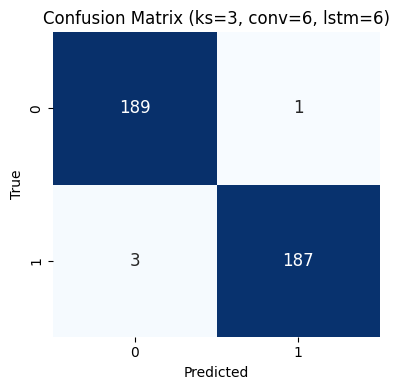

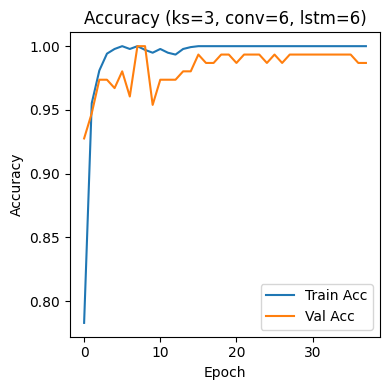

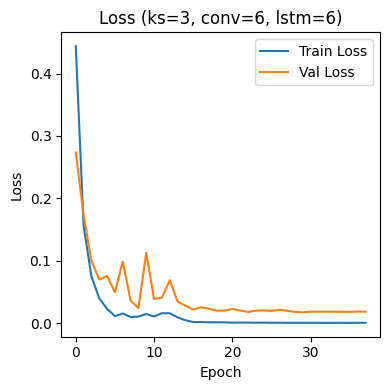

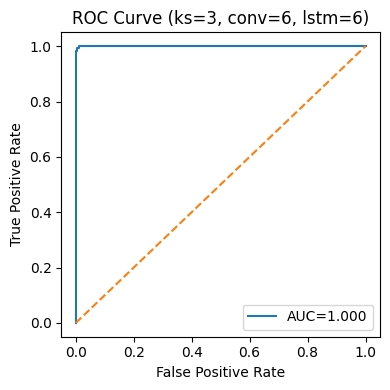

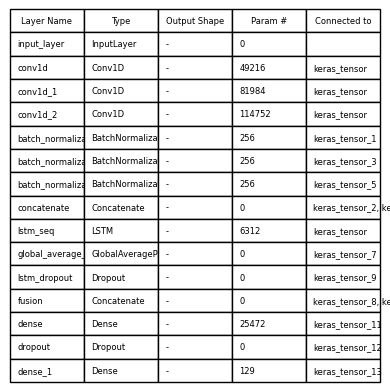


==================== FINAL RESULT ====================
Params: kernel_size=3, conv_layers=6, lstm_units=6
Accuracy:   0.9895
Sensitivity:0.9842  (Recall/TPR)
Specificity:0.9947  (TNR)
F1-score:   0.9894
Kappa:      0.9789
AUC:        0.9999
Bal.Acc:    0.9895
Confusion Matrix: TN=189, FP=1, FN=3, TP=187
Paths:
  Params CSV:  /kaggle/working/hybrid_cnn_lstm_multiscale_ks3_conv6_lstm6_params.csv
  Metrics JSON:    /kaggle/working/hybrid_cnn_lstm_multiscale_ks3_conv6_lstm6_final_metrics.json
  Metrics CSV:     /kaggle/working/hybrid_cnn_lstm_multiscale_ks3_conv6_lstm6_final_metrics.csv
  Report TXT:      /kaggle/working/hybrid_cnn_lstm_multiscale_ks3_conv6_lstm6_classification_report.txt
  Plots (output6):
     CM:    /kaggle/working/output6/hybrid_cnn_lstm_multiscale_ks3_conv6_lstm6_confusion_matrix_4x4.png
     ACC:   /kaggle/working/output6/hybrid_cnn_lstm_multiscale_ks3_conv6_lstm6_accuracy_curve_4x4.png
     LOSS:  /kaggle/working/output6/hybrid_cnn_lstm_multiscale_ks3_conv6_lstm6_l

In [13]:
import os
import json
import csv
import numpy as np
from scipy.signal import welch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             precision_score, recall_score, f1_score,
                             accuracy_score, balanced_accuracy_score,
                             cohen_kappa_score, roc_curve)
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models

# ------------------------- Repro & paths -------------------------------------
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
OUTDIR = "/kaggle/working"
OUTDIR2 = "/kaggle/working/output6"   # <— plots here
os.makedirs(OUTDIR, exist_ok=True)
os.makedirs(OUTDIR2, exist_ok=True)
KERNEL_SIZE = 3
NUM_CONV_LAYERS = 6
LSTM_UNITS = 6
STAMP = f"hybrid_cnn_lstm_multiscale_ks{KERNEL_SIZE}_conv{NUM_CONV_LAYERS}_lstm{LSTM_UNITS}"

# ------------------------- Load data -----------------------------------------
# X: (samples, height, width, time_points)
X = np.load('eeg_spatial_8x8.npy')
y = np.load('labels.npy').astype(int)
fs = 128
num_samples, height, width, time_points = X.shape

# frequency bands
bands = {'delta': (1, 4), 'theta': (4, 8), 'alpha': (8, 12), 'beta': (12, 30)}
num_bands = len(bands)

# sliding windows
window_size = 64
step_size = 32
num_windows = (time_points - window_size) // step_size + 1

# ------------------------- Feature extraction --------------------------------
def bandpower(signal, fs, nperseg, low, high):
    f, psd = welch(signal, fs=fs, nperseg=nperseg)
    idx = (f >= low) & (f <= high)
    return np.trapz(psd[idx], f[idx])

X_features = np.zeros((num_samples, num_windows, height * width * num_bands), dtype=np.float32)
for i in range(num_samples):
    for w in range(num_windows):
        start, end = w * step_size, w * step_size + window_size
        feats = []
        for r in range(height):
            for c in range(width):
                seg = X[i, r, c, start:end]
                if np.any(seg):
                    for (low, high) in bands.values():
                        feats.append(bandpower(seg, fs, window_size, low, high))
                else:
                    feats.extend([0.0]*num_bands)
        X_features[i, w, :] = np.asarray(feats, dtype=np.float32)

# ------------------------- Split, then scale (no leakage) --------------------
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_features, y, test_size=0.2, random_state=SEED, stratify=y
)

scaler = StandardScaler()
Ntr, T, F = X_train_raw.shape
Nte = X_test_raw.shape[0]
X_train = scaler.fit_transform(X_train_raw.reshape(-1, F)).reshape(Ntr, T, F)
X_test = scaler.transform(X_test_raw.reshape(-1, F)).reshape(Nte, T, F)

seq_len = T
feat_dim = F  # 8*8*4 = 256

# ------------------------- Build hybrid model with Multi-Scale Feature Extraction ------------------
def build_hybrid_cnn_lstm_multiscale(seq_len, feat_dim, num_conv_layers=6, kernel_size=3, lstm_units=6):
    inp = layers.Input(shape=(seq_len, feat_dim))  # (T, F)

    # --- Multi-scale CNN branch (temporal Conv1D over windows with different kernel sizes) ---
    convs = []
    kernel_sizes = [3, 5, 7]  # Define different kernel sizes for multi-scale feature extraction
    for ks in kernel_sizes:
        x = layers.Conv1D(filters=64, kernel_size=ks, padding="same", activation="relu")(inp)
        x = layers.BatchNormalization()(x)
        convs.append(x)
        
    # Concatenate the multi-scale features (different scales of temporal patterns)
    x = layers.Concatenate()(convs)
    x = layers.GlobalAveragePooling1D()(x)  # Aggregate the multi-scale features into a single vector
    conv_embed = x

    # --- LSTM branch (temporal modeling) ---
    y = layers.LSTM(lstm_units, return_sequences=False, name="lstm_seq")(inp)  # (B, T, lstm_units)
    y = layers.Dropout(0.2, name="lstm_dropout")(y)

    # --- Fusion ---
    z = layers.Concatenate(name="fusion")([conv_embed, y])  # (B, multi-scale + lstm_units)
    z = layers.Dense(128, activation="relu")(z)
    z = layers.Dropout(0.5)(z)
    out = layers.Dense(1, activation="sigmoid")(z)

    model = models.Model(inp, out, name=f"Hybrid_CNN_LSTM_MultiScale_{STAMP}")
    model.compile(optimizer="adam",
                  loss="binary_crossentropy",
                  metrics=["accuracy", tf.keras.metrics.AUC(name="auc")])
    return model

model = build_hybrid_cnn_lstm_multiscale(seq_len, feat_dim,
                              num_conv_layers=NUM_CONV_LAYERS,
                              kernel_size=KERNEL_SIZE,
                              lstm_units=LSTM_UNITS)

# ------------------------- Train ---------------------------------------------
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(OUTDIR, f"{STAMP}_best.h5"),
        monitor="val_loss", save_best_only=True, verbose=1
    )
]

history = model.fit(
    X_train, y_train,
    epochs=60,
    batch_size=64,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=2
)

# Save final model
final_model_path = os.path.join(OUTDIR, f"{STAMP}_final.h5")
model.save(final_model_path)
print(f"Saved model to {final_model_path}")

# ------------------------- Save parameter table ------------------------------
params_table_path = os.path.join(OUTDIR, f"{STAMP}_params.csv")
with open(params_table_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["param", "value"])
    writer.writerow(["kernel_size", KERNEL_SIZE])
    writer.writerow(["num_conv_layers", NUM_CONV_LAYERS])
    writer.writerow(["lstm_units", LSTM_UNITS])
    writer.writerow(["seq_len (T)", seq_len])
    writer.writerow(["feat_dim (F)", feat_dim])
    writer.writerow(["train_samples", len(y_train)])
    writer.writerow(["test_samples", len(y_test)])
print(f"Saved parameter table to {params_table_path}")

# ------------------------- Evaluate (FINAL RESULT) ---------------------------
y_pred_prob = model.predict(X_test, batch_size=256).ravel()
y_pred = (y_pred_prob >= 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)
prec = precision_score(y_test, y_pred, zero_division=0)
sens = recall_score(y_test, y_pred)              
spec = tn / (tn + fp) if (tn + fp) > 0 else 0.0  # specificity (TNR)
f1 = f1_score(y_test, y_pred)
bacc = balanced_accuracy_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)

final_results = {
    "params": {"kernel_size": KERNEL_SIZE,
               "num_conv_layers": NUM_CONV_LAYERS,
               "lstm_units": LSTM_UNITS, "seq_len": int(seq_len),
               "feat_dim": int(feat_dim)},
    "samples": {"train": int(len(y_train)), "test": int(len(y_test))},
    "metrics": {"accuracy": float(acc), "auc": float(auc),
                "precision": float(prec),
                "sensitivity_recall": float(sens), "specificity": float(spec),
                "f1": float(f1), "kappa": float(kappa),
                "balanced_accuracy": float(bacc),
                "tn": int(tn), "fp": int(fp), "fn": int(fn), "tp": int(tp)}
}

metrics_json_path = os.path.join(OUTDIR, f"{STAMP}_final_metrics.json")
with open(metrics_json_path, "w") as f: json.dump(final_results, f, indent=2)

metrics_csv_path = os.path.join(OUTDIR, f"{STAMP}_final_metrics.csv")
with open(metrics_csv_path, "w", newline="") as f:
    writer = csv.writer(f); writer.writerow(["metric", "value"])
    for k, v in final_results["metrics"].items(): writer.writerow([k, v])

report = classification_report(y_test, y_pred, digits=4)
report_path = os.path.join(OUTDIR, f"{STAMP}_classification_report.txt")
with open(report_path, "w") as f:
    f.write(f"Classification Report - {STAMP}\n\n")
    f.write(report)

# ------------------------- Plots (all 4×4) saved in output6 ------------------
title_suffix = f"(ks={KERNEL_SIZE}, conv={NUM_CONV_LAYERS}, lstm={LSTM_UNITS})"
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={"size": 12})
plt.title(f'Confusion Matrix {title_suffix}')
plt.xlabel('Predicted'); plt.ylabel('True')
cm_path = os.path.join(OUTDIR2, f"{STAMP}_confusion_matrix_4x4.png")
plt.tight_layout(); plt.savefig(cm_path, dpi=200); plt.show()

plt.figure(figsize=(4, 4))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title(f'Accuracy {title_suffix}')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()
acc_curve_path = os.path.join(OUTDIR2, f"{STAMP}_accuracy_curve_4x4.png")
plt.tight_layout(); plt.savefig(acc_curve_path, dpi=200); plt.show()

plt.figure(figsize=(4, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title(f'Loss {title_suffix}')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
loss_curve_path = os.path.join(OUTDIR2, f"{STAMP}_loss_curve_4x4.png")
plt.tight_layout(); plt.savefig(loss_curve_path, dpi=200); plt.show()

fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, label=f'AUC={auc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title(f'ROC Curve {title_suffix}'); plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
roc_curve_path = os.path.join(OUTDIR2, f"{STAMP}_roc_curve_4x4.png")
plt.tight_layout(); plt.savefig(roc_curve_path, dpi=200); plt.show()

# ------------------------- Model summary table (CSV + PNG) -------------------
rows = []
for layer in model.layers:
    layer_type = layer.__class__.__name__
    name = layer.name
    try: out_shape = layer.output_shape
    except: out_shape = "-"
    params = layer.count_params()
    try:
        inbound = layer.input
        if isinstance(inbound, (list, tuple)):
            conn = ", ".join([getattr(t, "name", "-") for t in inbound])
        else:
            conn = getattr(inbound, "name", "-")
    except: conn = "-"
    rows.append([name, layer_type, str(out_shape), params, conn])

model_table_csv = os.path.join(OUTDIR, f"{STAMP}_model_table.csv")
with open(model_table_csv, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Layer Name", "Type", "Output Shape", "Param #", "Connected to"])
    writer.writerows(rows)

fig, ax = plt.subplots(figsize=(4, 4)); ax.axis('off')
table = plt.table(cellText=rows,
                  colLabels=["Layer Name", "Type", "Output Shape", "Param #", "Connected to"],
                  loc='center', cellLoc='left')
table.auto_set_font_size(False); table.set_fontsize(6);
table.scale(1, 1.3)
model_table_png = os.path.join(OUTDIR2, f"{STAMP}_model_table.png")
plt.tight_layout(); plt.savefig(model_table_png, dpi=200); plt.show()

print("\n==================== FINAL RESULT ====================")
print(f"Params: kernel_size={KERNEL_SIZE}, conv_layers={NUM_CONV_LAYERS}, lstm_units={LSTM_UNITS}")
print(f"Accuracy:   {acc:.4f}")
print(f"Sensitivity:{sens:.4f}  (Recall/TPR)")
print(f"Specificity:{spec:.4f}  (TNR)")
print(f"F1-score:   {f1:.4f}")
print(f"Kappa:      {kappa:.4f}")
print(f"AUC:        {auc:.4f}")
print(f"Bal.Acc:    {bacc:.4f}")
print(f"Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")
print("Paths:")
print("  Params CSV: ", params_table_path)
print("  Metrics JSON:   ", metrics_json_path)
print("  Metrics CSV:    ", metrics_csv_path)
print("  Report TXT:     ", report_path)
print("  Plots (output6):")
print("     CM:   ", cm_path)
print("     ACC:  ", acc_curve_path)
print("     LOSS: ", loss_curve_path)
print("     ROC:  ", roc_curve_path)
print("     Model table PNG:", model_table_png)
print("  Model table CSV:", model_table_csv)
print("  Best model:     ", os.path.join(OUTDIR, f'{STAMP}_best.h5'))
print("  Final model:    ", os.path.join(OUTDIR, f'{STAMP}_final.h5'))
print("===============================================\n")


In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ---- directory for bandpower plots (inside your OUTDIR2) ----
BP_OUTDIR = os.path.join(OUTDIR2, "bandpower_evolution")
os.makedirs(BP_OUTDIR, exist_ok=True)

# band labels (same order as in your `bands` dict)
band_labels = ["Delta (1–4 Hz)", "Theta (4–8 Hz)",
               "Alpha (8–12 Hz)", "Beta (12–30 Hz)"]

def plot_bandpower_evolution_for_sample(X_features,
                                        sample_idx,
                                        window_indices,
                                        band_idx,
                                        height=8,
                                        width=8,
                                        band_labels=None,
                                        filename_prefix="msfusionnet"):
    """
    Visualise bandpower as 8×8 spatial maps over several time windows,
    similar to your PLV temporal evolution plot.

    X_features:   (num_samples, num_windows, height*width*num_bands)
    sample_idx:   which trial/sample to visualise
    window_indices: list of window indices, e.g. [0, 1, 2]
    band_idx:     which band to show (0:delta, 1:theta, 2:alpha, 3:beta)
    """
    num_bands = int(X_features.shape[-1] // (height * width))
    if band_labels is None:
        band_labels = [f"Band {i}" for i in range(num_bands)]

    n_seg = len(window_indices)
    plt.figure(figsize=(5 * n_seg, 5))

    # global min/max for consistent colour scale
    # (only this band, across the chosen windows)
    all_maps = []
    for w in window_indices:
        vec = X_features[sample_idx, w, :]
        cube = vec.reshape(height, width, num_bands)    # (8, 8, 4)
        all_maps.append(cube[:, :, band_idx])
    vmin = np.min(all_maps)
    vmax = np.max(all_maps)

    for i, w in enumerate(window_indices):
        plt.subplot(1, n_seg, i + 1)
        vec = X_features[sample_idx, w, :]
        cube = vec.reshape(height, width, num_bands)    # (8, 8, 4)
        band_map = cube[:, :, band_idx]                 # (8, 8) for one band

        sns.heatmap(band_map,
                    cmap="viridis",
                    vmin=vmin, vmax=vmax,
                    square=True,
                    cbar=(i == n_seg - 1))  # show one colorbar on last panel
        plt.title(f"Window {w}")
        plt.axis("off")

    plt.suptitle(f"Temporal Evolution of Bandpower – {band_labels[band_idx]}",
                 y=0.92)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)

    fname = f"{filename_prefix}_sample{sample_idx}_band{band_idx}.png"
    save_path = os.path.join(BP_OUTDIR, fname)
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()
    print(f"Saved plot: {save_path}")


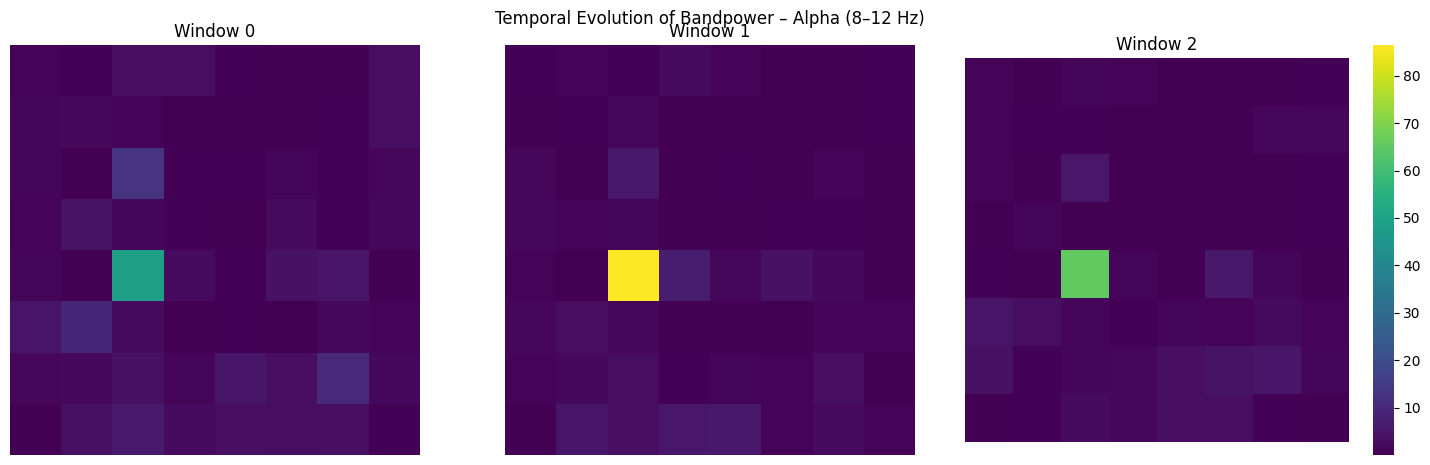

Saved plot: /kaggle/working/output6/bandpower_evolution/temporal_evolution_bandpower_sample0_band2.png


In [22]:
# e.g. show Alpha band for sample 0, windows 0,1,2
plot_bandpower_evolution_for_sample(
    X_features=X_features,
    sample_idx=0,
    window_indices=[0, 1, 2],
    band_idx=2,                      # 0:delta, 1:theta, 2:alpha, 3:beta
    band_labels=band_labels,
    filename_prefix="temporal_evolution_bandpower"
)


In [23]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ---- directory for bandpower plots (inside your OUTDIR2) ----
BP_OUTDIR = os.path.join(OUTDIR2, "bandpower_evolution")
os.makedirs(BP_OUTDIR, exist_ok=True)

# band labels (same order as in your `bands` dict)
band_labels = ["Delta (1–4 Hz)", "Theta (4–8 Hz)",
               "Alpha (8–12 Hz)", "Beta (12–30 Hz)"]

def plot_bandpower_evolution_for_sample(X_features,
                                        sample_idx,
                                        window_indices,
                                        band_idx,
                                        height=8,
                                        width=8,
                                        band_labels=None,
                                        filename_prefix="msfusionnet"):
    """
    Visualise bandpower as 8×8 spatial maps over several time windows.

    X_features:     (num_samples, num_windows, height*width*num_bands)
    sample_idx:     which trial/sample to visualise
    window_indices: list of window indices, e.g. [0, 1, 2]
    band_idx:       which band to show (0:delta, 1:theta, 2:alpha, 3:beta)
    """
    num_bands = int(X_features.shape[-1] // (height * width))
    if band_labels is None:
        band_labels = [f"Band {i}" for i in range(num_bands)]

    n_seg = len(window_indices)
    plt.figure(figsize=(5 * n_seg, 5))

    # global min/max for consistent colour scale across panels for this band
    all_maps = []
    for w in window_indices:
        vec = X_features[sample_idx, w, :]
        cube = vec.reshape(height, width, num_bands)    # (8, 8, 4)
        all_maps.append(cube[:, :, band_idx])
    vmin = np.min(all_maps)
    vmax = np.max(all_maps)

    for i, w in enumerate(window_indices):
        plt.subplot(1, n_seg, i + 1)
        vec = X_features[sample_idx, w, :]
        cube = vec.reshape(height, width, num_bands)
        band_map = cube[:, :, band_idx]

        sns.heatmap(band_map,
                    cmap="viridis",
                    vmin=vmin, vmax=vmax,
                    square=True,
                    cbar=(i == n_seg - 1))
        plt.title(f"Window {w}")
        plt.axis("off")

    plt.suptitle(f"Temporal Evolution of Bandpower – {band_labels[band_idx]}",
                 y=0.92)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)

    fname = f"{filename_prefix}_sample{sample_idx}_band{band_idx}.png"
    save_path = os.path.join(BP_OUTDIR, fname)
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()
    print(f"Saved plot: {save_path}")


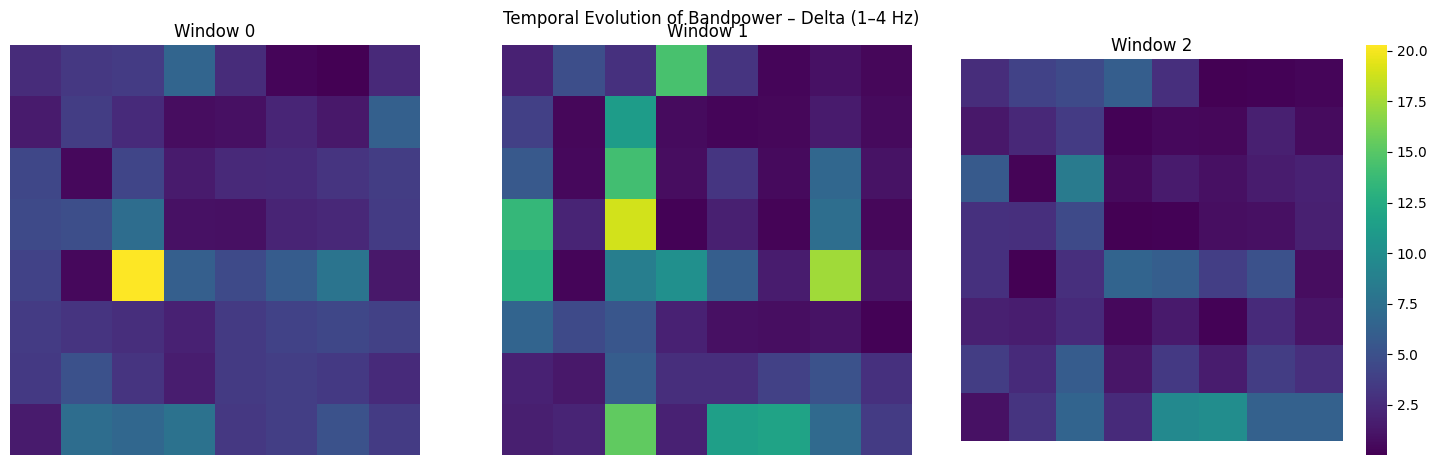

Saved plot: /kaggle/working/output6/bandpower_evolution/temporal_evolution_bandpower_delta_sample0_band0.png


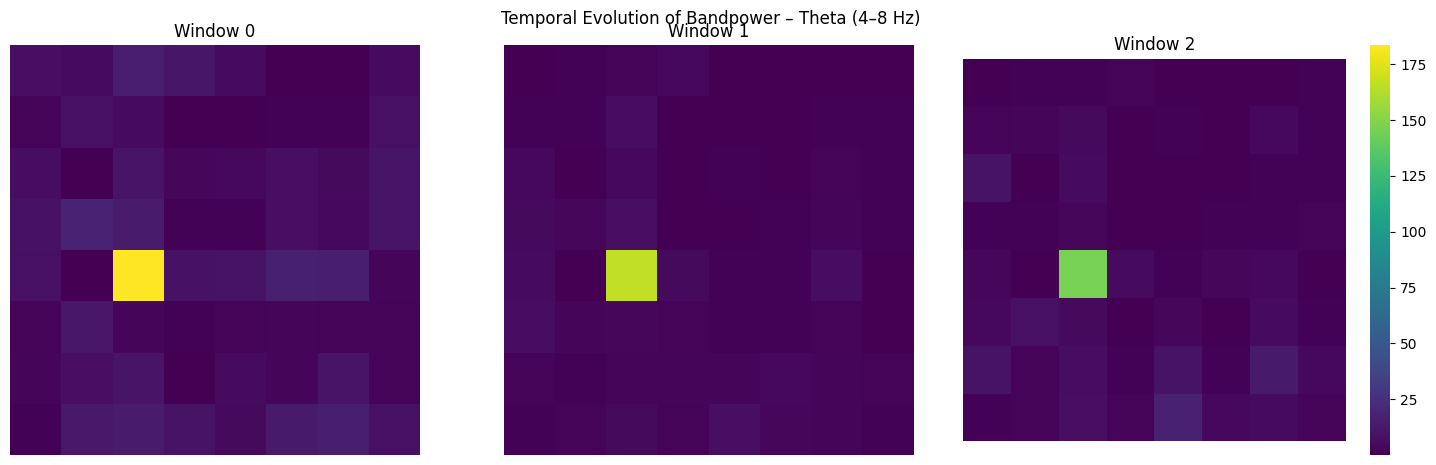

Saved plot: /kaggle/working/output6/bandpower_evolution/temporal_evolution_bandpower_theta_sample0_band1.png


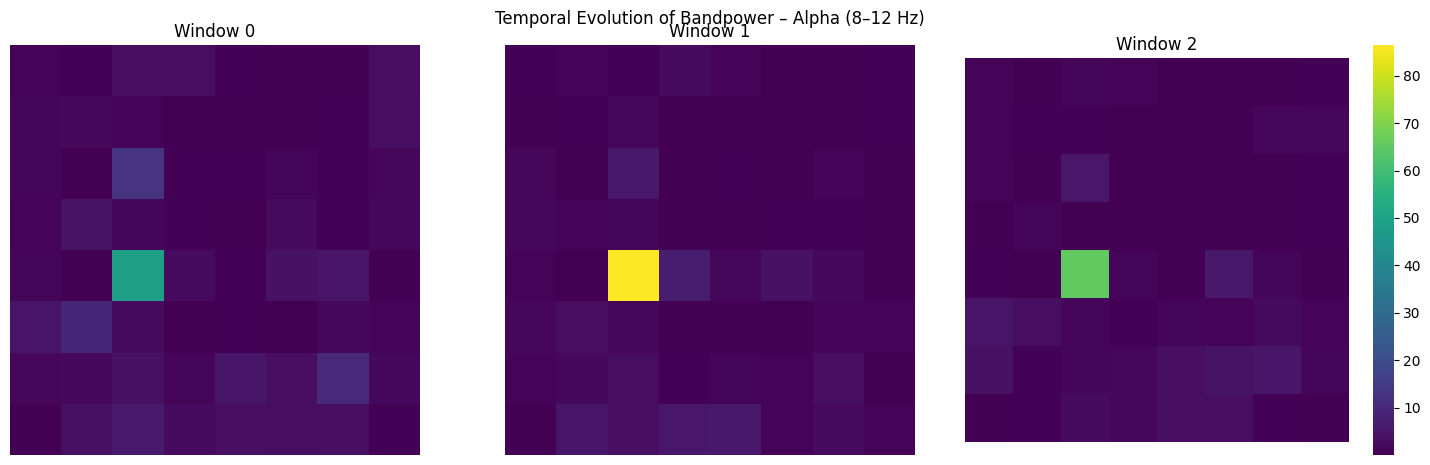

Saved plot: /kaggle/working/output6/bandpower_evolution/temporal_evolution_bandpower_alpha_sample0_band2.png


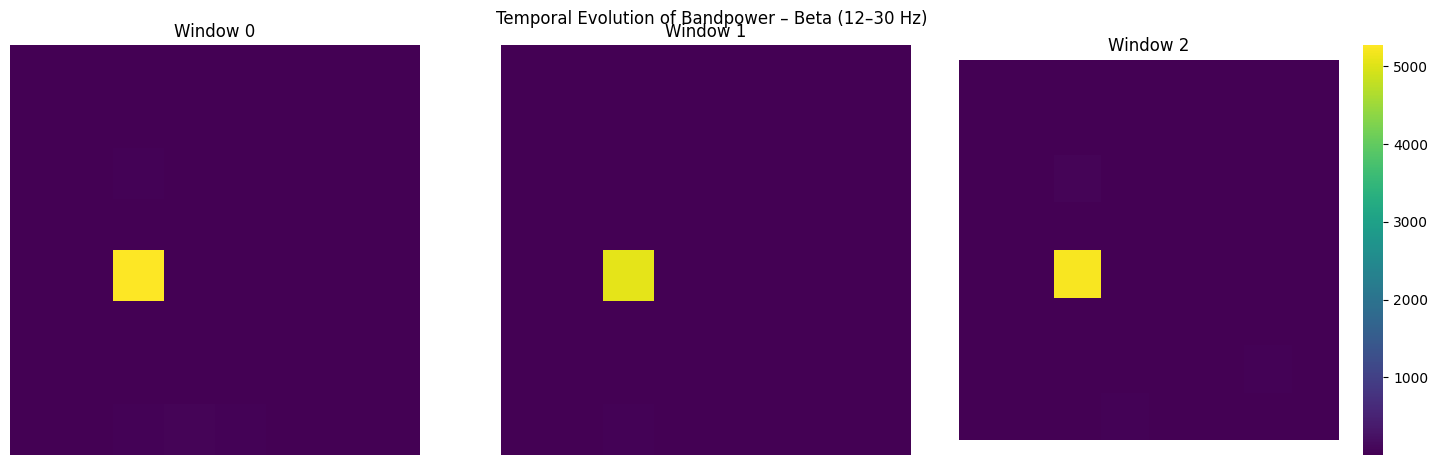

Saved plot: /kaggle/working/output6/bandpower_evolution/temporal_evolution_bandpower_beta_sample0_band3.png


In [24]:
sample_idx = 0             # choose any sample you like
window_indices = [0, 1, 2] # same style as your PLV figure

for band_idx, label in enumerate(band_labels):
    prefix = f"temporal_evolution_bandpower_{label.split()[0].lower()}"  # delta/theta/alpha/beta
    plot_bandpower_evolution_for_sample(
        X_features=X_features,
        sample_idx=sample_idx,
        window_indices=window_indices,
        band_idx=band_idx,
        band_labels=band_labels,
        filename_prefix=prefix
    )


In [26]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

OUTDIR_FUSION = "/kaggle/working/feature_evolution_plots"
os.makedirs(OUTDIR_FUSION, exist_ok=True)

band_labels = ["Delta (1–4 Hz)", "Theta (4–8 Hz)",
               "Alpha (8–12 Hz)", "Beta (12–30 Hz)"]

def plot_temporal_evolution_psd_bp_plv(psd_seq,
                                       bp_seq,
                                       plv_seq,
                                       seg_indices,
                                       bp_band_idx=2,   # e.g. Alpha
                                       psd_title_band="PSD (1–50 Hz)",
                                       filename_prefix="temporal_evolution_all"):
    """
    Create a figure with 3 rows:
        Row 1: temporal evolution of PSD (segments × channels×freq)
        Row 2: temporal evolution of Bandpower (segments × channels×bands)
        Row 3: temporal evolution of PLV connectivity (segments × channels×channels)

    psd_seq: (num_segments, num_channels, num_freqs)
    bp_seq:  (num_segments, num_channels, num_bands)
    plv_seq: (num_segments, num_channels, num_channels)
    seg_indices: list of segment indices to plot, e.g. [0, 1, 2]
    bp_band_idx: which band to show in the bandpower row (0..num_bands-1)
    """
    n_seg = len(seg_indices)
    num_channels = bp_seq.shape[1]
    num_bands = bp_seq.shape[2]
    num_freqs = psd_seq.shape[2]

    fig, axes = plt.subplots(3, n_seg, figsize=(5 * n_seg, 12))

    # ---------- 1) PSD row ----------
    # we will plot channels × freq for each segment
    for col, s in enumerate(seg_indices):
        ax = axes[0, col] if n_seg > 1 else axes[0]
        psd_map = psd_seq[s]   # (channels, freqs)
        sns.heatmap(psd_map,
                    ax=ax,
                    cmap="magma",
                    cbar=(col == n_seg - 1))
        ax.set_title(f"Segment {s}")
        ax.set_ylabel("Channel")
        ax.set_xlabel("Freq bin")
    axes[0, 0].set_ylabel("Channel", fontsize=11)
    fig.text(0.02, 0.84, psd_title_band, fontsize=13, rotation=90, va="center")

    # ---------- 2) Bandpower row ----------
    # channels × bands for chosen band, or show all bands as second dim
    for col, s in enumerate(seg_indices):
        ax = axes[1, col] if n_seg > 1 else axes[1]
        bp_map = bp_seq[s]  # (channels, num_bands)
        # If you prefer a single band as 8×8, you could reshape here instead.
        sns.heatmap(bp_map.T,   # bands × channels
                    ax=ax,
                    cmap="viridis",
                    cbar=(col == n_seg - 1))
        ax.set_title(f"Segment {s}")
        ax.set_yticks(np.arange(0.5, num_bands + 0.5))
        ax.set_yticklabels(band_labels[:num_bands], rotation=0)
        ax.set_xlabel("Channel")
    axes[1, 0].set_ylabel("Band", fontsize=11)
    fig.text(0.02, 0.52, "Bandpower", fontsize=13, rotation=90, va="center")

    # ---------- 3) PLV row ----------
    for col, s in enumerate(seg_indices):
        ax = axes[2, col] if n_seg > 1 else axes[2]
        plv_map = plv_seq[s]  # (channels, channels)
        sns.heatmap(plv_map,
                    ax=ax,
                    cmap="coolwarm",
                    vmin=0, vmax=1,
                    square=True,
                    cbar=(col == n_seg - 1))
        ax.set_title(f"Segment {s}")
        ax.set_xlabel("Channel")
        ax.set_ylabel("Channel")
    fig.text(0.02, 0.20, "PLV Connectivity", fontsize=13, rotation=90, va="center")

    # ---------- global title & saving ----------
    fig.suptitle("Temporal Evolution of PSD, Bandpower, and PLV Connectivity",
                 fontsize=16, y=0.97)
    plt.tight_layout(rect=[0.04, 0.03, 1.0, 0.93])

    fname = f"{filename_prefix}_segments_" + "_".join(map(str, seg_indices)) + ".png"
    save_path = os.path.join(OUTDIR_FUSION, fname)
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()
    print(f"Saved combined figure: {save_path}")


In [30]:
import numpy as np
import tensorflow as tf
import scipy.signal as signal
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import pickle
import os
from sklearn.metrics import classification_report  # Import classification metrics

# Check the uploaded files (you should already know the file is uploaded)
print(os.listdir())  # This lists all files in the current directory

# Load the data from the uploaded file
file_path = '/kaggle/input/datasetttt/combined_data_new2.dat'  # Direct file path after upload
with open(file_path, 'rb') as file:
    data_dict = pickle.load(file)

# Extract data and labels
data = data_dict['data']  # Shape: (num_samples, num_channels, num_time_points)
labels = data_dict['labels']  # Shape: (num_samples,)

num_samples, num_channels, num_time_points = data.shape
print(f"Number of samples: {num_samples}, Channels: {num_channels}, Time points: {num_time_points}")

# Bandpass Filter Function
def bandpass_filter(data, lowcut=1, highcut=50, fs=256, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    return signal.filtfilt(b, a, data)

# Power Spectral Density (PSD) computation function
def compute_psd(data, fs=256, nperseg=128):
    n_samples, n_channels, n_timepoints = data.shape
    psd_data = []
    for i in range(n_channels):
        channel_data = data[:, i, :]
        psd_per_channel = []
        for signal_data in channel_data:
            f, Pxx = signal.welch(signal_data, fs=fs, nperseg=nperseg)
            Pxx_log = np.log(Pxx + 1e-10)  # Avoid log(0)
            psd_per_channel.append(Pxx_log)
        psd_data.append(np.array(psd_per_channel))
    psd_data = np.array(psd_data)  # Shape: (n_channels, n_samples, n_freqs)
    return np.transpose(psd_data, (1, 0, 2))  # Shape: (n_samples, n_channels, n_freqs)

# Preprocess Data
filtered_data = np.zeros_like(data)
for i in range(num_channels):
    for j in range(num_samples):
        filtered_data[j, i, :] = bandpass_filter(data[j, i, :])  # Apply bandpass filter to each signal

# Compute PSD for filtered data
psd_data = compute_psd(filtered_data)

# Standardize the PSD data
num_samples, num_channels, num_freqs = psd_data.shape
psd_data = psd_data.reshape(-1, num_freqs)  # Flatten
scaler = StandardScaler()
psd_data = scaler.fit_transform(psd_data)
psd_data = psd_data.reshape(num_samples, num_channels, num_freqs)  # Reshape back

# PCA for dimensionality reduction (optional)
pca = PCA(n_components=20)  # Reduce to 20 components
psd_data_reduced = []
for channel in range(num_channels):
    channel_data = psd_data[:, channel, :]
    reduced_data = pca.fit_transform(channel_data)
    psd_data_reduced.append(reduced_data)

psd_data_reduced = np.stack(psd_data_reduced, axis=1)  # Shape: (num_samples, num_channels, 20)

# Compute class weights for imbalance handling
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weight_dict = dict(enumerate(class_weights))


['feature_evolution_plots', 'labels.npy', 'hybrid_cnn_lstm_multiscale_ks3_conv6_lstm6_final_metrics.csv', 'output6', 'hybrid_cnn_lstm_multiscale_ks3_conv6_lstm6_final.h5', 'hybrid_cnn_lstm_multiscale_ks3_conv6_lstm6_final_metrics.json', 'hybrid_cnn_lstm_multiscale_ks3_conv6_lstm6_model_table.csv', 'hybrid_cnn_lstm_multiscale_ks3_conv6_lstm6_params.csv', 'hybrid_cnn_lstm_multiscale_ks3_conv6_lstm6_classification_report.txt', '.virtual_documents', 'hybrid_cnn_lstm_multiscale_ks3_conv6_lstm6_best.h5', 'eeg_spatial_8x8.npy']
Number of samples: 948, Channels: 64, Time points: 256


In [31]:
psd_data = compute_psd(filtered_data)  # shape: (num_samples, num_channels, num_freqs)


In [32]:
psd_seq = psd_data      # (num_segments, num_channels, num_freqs)


In [33]:
# X_features: (num_samples, num_windows, 8*8*4)
# height = width = 8, num_bands = 4
num_samples, num_windows, flat_dim = X_features.shape
height = width = 8
num_bands = 4
num_channels = height * width

bp_seq_list = []
for s in range(num_windows):        # treat each window as a "segment"
    # average over samples to visualise mean bandpower per window
    window_data = X_features[:, s, :]                 # (num_samples, 8*8*4)
    window_mean = window_data.mean(axis=0)            # (8*8*4,)
    cube = window_mean.reshape(height*width, num_bands)  # (64, 4)
    bp_seq_list.append(cube)

bp_seq = np.stack(bp_seq_list, axis=0)  # (num_segments=num_windows, channels=64, num_bands=4)


In [34]:
# X_plv: (num_segments, num_channels, num_channels)
plv_seq = X_plv


NameError: name 'X_plv' is not defined

In [35]:
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder

def load_csv_folder(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = [pd.read_csv(f) for f in all_files]
    combined_df = pd.concat(df_list, ignore_index=True)
    return combined_df

train_folder = '/kaggle/input/Alcoholics/SMNI_CMI_TRAIN'
test_folder = '/kaggle/input/Alcoholics/SMNI_CMI_TEST'

train_df = load_csv_folder(train_folder)
test_df = load_csv_folder(test_folder)

print("Train data shape:", train_df.shape)
print("Test data shape:", test_df.shape)

# Assuming EEG channels columns are known, e.g.
eeg_cols = ['C3', 'C4', 'CZ']  # replace with your actual EEG channel column names

X_train = train_df[eeg_cols].values
y_train_raw = train_df['subject identifier'].values  # exact column name might vary

X_test = test_df[eeg_cols].values
y_test_raw = test_df['subject identifier'].values


Train data shape: (7667712, 10)
Test data shape: (7864320, 10)


KeyError: "None of [Index(['C3', 'C4', 'CZ'], dtype='object')] are in the [columns]"

In [36]:
# Make sure 'sample num' and 'channel' uniquely identify each waveform point for each trial
eeg_df = train_df.pivot_table(
    index=['subject identifier', 'trial number', 'sample num'],   # rows: each point in each trial
    columns='sensor position',                                    # columns: each sensor/channel
    values='sensor value'                                         # values: signal at that sample
)

eeg_df = eeg_df.reset_index()
print(eeg_df.head())
print("EEG pivot shape:", eeg_df.shape)

sensor position subject identifier  trial number  sample num       AF1  \
0                                a             0           0 -0.832714   
1                                a             0           1 -0.832714   
2                                a             0           2 -0.344286   
3                                a             0           3  0.143714   
4                                a             0           4  1.329857   

sensor position       AF2       AF7       AF8       AFZ        C1        C2  \
0               -0.074143 -3.396143 -0.453429 -0.357429  0.011571  1.062143   
1                0.135286 -1.791714  0.244286 -0.427143 -0.197571  0.225000   
2                0.274571  1.277429  1.430000 -0.008857  0.290714  0.225143   
3                0.414286  4.416286  2.755286  0.410000  0.499857 -0.053857   
4                1.181429  6.020571  3.522571  1.316714  0.778857  0.364714   

sensor position  ...       PO8       POZ        PZ        T7        T8  \
0     

In [37]:
eeg_cols = eeg_df.columns[eeg_df.columns.get_loc('sample num')+1:]  # all sensor columns after time indices
arr_eeg = eeg_df[eeg_cols].values  # shape: (num_points, num_channels)
raw_labels = eeg_df['subject identifier'].values

In [38]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
subject_labels = le.fit_transform(raw_labels)  # integer label for each EEG point/window
print("Subject label classes:", le.classes_)

Subject label classes: ['a' 'c']


In [39]:
# raw_labels is your array of subject identifier strings
import numpy as np

label_map = {'a': 1, 'c': 0}
subject_labels = np.array([label_map[lbl] for lbl in raw_labels])
print(np.unique(subject_labels, return_counts=True))  # Should print (array([0, 1]), counts)


(array([0, 1]), array([15616, 11776]))


In [44]:
def sequence_labels(windowed_labels, time_steps):
    seq_labels = []
    for i in range(len(windowed_labels) - time_steps + 1):
        vals, counts = np.unique(windowed_labels[i:i+time_steps], return_counts=True)
        seq_label = vals[np.argmax(counts)]
        seq_labels.append(seq_label)
    return np.array(seq_labels)


In [47]:
# Make sure segments is a NumPy array
segments = np.array(segments)

# Now you can safely get shape
n_channels = segments.shape[-1]  # segments shape: (num_segments, window_size, n_channels)
input_shape = (time_steps, n_channels, n_channels, 1)

print("n_channels:", n_channels)
print("input_shape:", input_shape)

NameError: name 'segments' is not defined

In [48]:
print(train_df.columns)
print(test_df.columns)

Index(['Unnamed: 0', 'trial number', 'sensor position', 'sample num',
       'sensor value', 'subject identifier', 'matching condition', 'channel',
       'name', 'time'],
      dtype='object')
Index(['Unnamed: 0', 'trial number', 'sensor position', 'sample num',
       'sensor value', 'subject identifier', 'matching condition', 'channel',
       'name', 'time'],
      dtype='object')


In [49]:
# Make sure 'sample num' and 'channel' uniquely identify each waveform point for each trial
eeg_df = train_df.pivot_table(
    index=['subject identifier', 'trial number', 'sample num'],   # rows: each point in each trial
    columns='sensor position',                                    # columns: each sensor/channel
    values='sensor value'                                         # values: signal at that sample
)

eeg_df = eeg_df.reset_index()
print(eeg_df.head())
print("EEG pivot shape:", eeg_df.shape)

sensor position subject identifier  trial number  sample num       AF1  \
0                                a             0           0 -0.832714   
1                                a             0           1 -0.832714   
2                                a             0           2 -0.344286   
3                                a             0           3  0.143714   
4                                a             0           4  1.329857   

sensor position       AF2       AF7       AF8       AFZ        C1        C2  \
0               -0.074143 -3.396143 -0.453429 -0.357429  0.011571  1.062143   
1                0.135286 -1.791714  0.244286 -0.427143 -0.197571  0.225000   
2                0.274571  1.277429  1.430000 -0.008857  0.290714  0.225143   
3                0.414286  4.416286  2.755286  0.410000  0.499857 -0.053857   
4                1.181429  6.020571  3.522571  1.316714  0.778857  0.364714   

sensor position  ...       PO8       POZ        PZ        T7        T8  \
0     

In [51]:
eeg_cols = eeg_df.columns[eeg_df.columns.get_loc('sample num')+1:]  # all sensor columns after time indices
arr_eeg = eeg_df[eeg_cols].values  # shape: (num_points, num_channels)
raw_labels = eeg_df['subject identifier'].values

In [52]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
subject_labels = le.fit_transform(raw_labels)  # integer label for each EEG point/window
print("Subject label classes:", le.classes_)

Subject label classes: ['a' 'c']


In [53]:
import numpy as np

win_size = 2 * 256     # 2 seconds window assuming 256 Hz sampling
step_size = 256       # 50% overlap

segments = []
labels = []

# Group EEG by trial number to preserve sequence order
for trial_num, group in eeg_df.groupby('trial number'):
    eeg_data = group[eeg_cols].values
    subject_label = group['subject identifier'].iloc[0]  # same for whole trial
    
    for start in range(0, len(eeg_data) - win_size + 1, step_size):
        segment = eeg_data[start:start+win_size, :]
        segments.append(segment)
        labels.append(subject_label)

segments = np.array(segments)
labels = np.array(labels)
print("Segments shape:", segments.shape)
print("Labels shape:", labels.shape)

Segments shape: (45, 512, 64)
Labels shape: (45,)


In [54]:
from scipy.signal import hilbert

def plv_matrix(window):
    analytic = hilbert(window, axis=0)
    phases = np.angle(analytic)
    n = phases.shape[1]
    plv = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            phase_diff = phases[:, i] - phases[:, j]
            val = np.abs(np.sum(np.exp(1j * phase_diff))) / len(phase_diff)
            plv[i, j] = val
            plv[j, i] = val
    return plv

X_plv = np.stack([plv_matrix(seg) for seg in segments])
print("PLV data shape:", X_plv.shape)




PLV data shape: (45, 64, 64)


In [55]:

# raw_labels is your array of subject identifier strings
import numpy as np

label_map = {'a': 1, 'c': 0}
subject_labels = np.array([label_map[lbl] for lbl in raw_labels])
print(np.unique(subject_labels, return_counts=True))  # Should print (array([0, 1]), counts)

(array([0, 1]), array([15616, 11776]))


In [58]:
def sequence_labels(windowed_labels, time_steps):
    seq_labels = []
    for i in range(len(windowed_labels) - time_steps + 1):
        vals, counts = np.unique(windowed_labels[i:i+time_steps], return_counts=True)
        seq_label = vals[np.argmax(counts)]
        seq_labels.append(seq_label)
    return np.array(seq_labels)

In [59]:
y = sequence_labels(subject_labels, time_steps)

NameError: name 'time_steps' is not defined

In [60]:
# Create sequences of PLV windows
X_seq = create_sequences(X_plv, time_steps)
X_seq = X_seq[..., np.newaxis]  # Add channel dim for CNN input

# Create sequence labels by majority vote in each sequence window
y_seq = sequence_labels(subject_labels, time_steps)

print("Sequence data shape:", X_seq.shape)
print("Sequence labels shape:", y_seq.shape)

NameError: name 'create_sequences' is not defined

In [62]:
segments = np.array(segments)
print("Segments array shape:", segments.shape)
n_channels = segments.shape[-1]
print("n_channels:", n_channels)

Segments array shape: (45, 512, 64)
n_channels: 64


In [63]:
print("Number of segments extracted:", len(segments))

Number of segments extracted: 45


In [66]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

FEV_OUTDIR = os.path.join(OUTDIR2, "psd_bandpower_evolution")
os.makedirs(FEV_OUTDIR, exist_ok=True)

band_labels = ["Delta (1–4 Hz)", "Theta (4–8 Hz)",
               "Alpha (8–12 Hz)", "Beta (12–30 Hz)"]

def plot_temporal_evolution_psd_bp(psd_seq,
                                   bp_seq,
                                   seg_indices,
                                   filename_prefix="temporal_evolution_psd_bp"):
    """
    Create a figure with 2 rows and len(seg_indices) columns:

      Row 1: PSD  (channels × freq)
      Row 2: Bandpower (bands × channels)

    psd_seq: (num_segments, num_channels, num_freqs)
    bp_seq:  (num_segments, num_channels, num_bands)
    seg_indices: list of segment indices to plot, e.g. [0, 1, 2]
    """

    n_seg = len(seg_indices)
    num_channels = bp_seq.shape[1]
    num_bands = bp_seq.shape[2]
    num_freqs = psd_seq.shape[2]

    fig, axes = plt.subplots(2, n_seg, figsize=(5 * n_seg, 8))

    # ---------- 1) PSD row ----------
    for col, s in enumerate(seg_indices):
        ax = axes[0, col] if n_seg > 1 else axes[0]
        psd_map = psd_seq[s]   # (channels, freqs)
        sns.heatmap(psd_map,
                    ax=ax,
                    cmap="magma",
                    cbar=(col == n_seg - 1))
        ax.set_title(f"Segment {s}")
        ax.set_ylabel("Channel")
        ax.set_xlabel("Freq bin")
    axes[0, 0].set_ylabel("Channel", fontsize=11)
    fig.text(0.02, 0.66, "PSD", fontsize=13, rotation=90, va="center")

    # ---------- 2) Bandpower row ----------
    for col, s in enumerate(seg_indices):
        ax = axes[1, col] if n_seg > 1 else axes[1]
        bp_map = bp_seq[s]  # (channels, num_bands)
        # plot bands × channels (so y-axis = bands)
        sns.heatmap(bp_map.T,
                    ax=ax,
                    cmap="viridis",
                    cbar=(col == n_seg - 1))
        ax.set_title(f"Segment {s}")
        ax.set_yticks(np.arange(0.5, num_bands + 0.5))
        ax.set_yticklabels(band_labels[:num_bands], rotation=0)
        ax.set_xlabel("Channel")
    axes[1, 0].set_ylabel("Band", fontsize=11)
    fig.text(0.02, 0.32, "Bandpower", fontsize=13, rotation=90, va="center")

    # ---------- global title & saving ----------
    fig.suptitle("Temporal Evolution of PSD and Bandpower",
                 fontsize=16, y=0.98)
    plt.tight_layout(rect=[0.05, 0.03, 1.0, 0.93])

    fname = f"{filename_prefix}_segments_" + "_".join(map(str, seg_indices)) + ".png"
    save_path = os.path.join(FEV_OUTDIR, fname)
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()
    print(f"Saved combined figure: {save_path}")


In [67]:
psd_data = compute_psd(filtered_data)  # (num_samples, num_channels, num_freqs)


In [69]:
psd_seq = psd_data  # treat each sample as a "segment"


In [70]:
# X_features: (num_samples, num_windows, 8*8*4)
num_samples, num_windows, flat_dim = X_features.shape
height = width = 8
num_bands = 4
num_channels = height * width  # 64


In [71]:
bp_seq_list = []
for w in range(num_windows):              # each window = one "segment"
    window_data = X_features[:, w, :]     # (num_samples, 8*8*4)
    window_mean = window_data.mean(axis=0)  # (8*8*4,)
    cube = window_mean.reshape(num_channels, num_bands)  # (64, 4)
    bp_seq_list.append(cube)

bp_seq = np.stack(bp_seq_list, axis=0)    # (num_segments=num_windows, 64, 4)


In [73]:
psd_seq.shape -> (num_psd_segments, num_channels_psd, num_freqs)
bp_seq.shape  -> (num_windows, 64, 4)


SyntaxError: invalid syntax (1523569871.py, line 1)

In [74]:
segments_to_show = [0, 1, 2]  # make sure 0,1,2 < psd_seq.shape[0] and < bp_seq.shape[0]


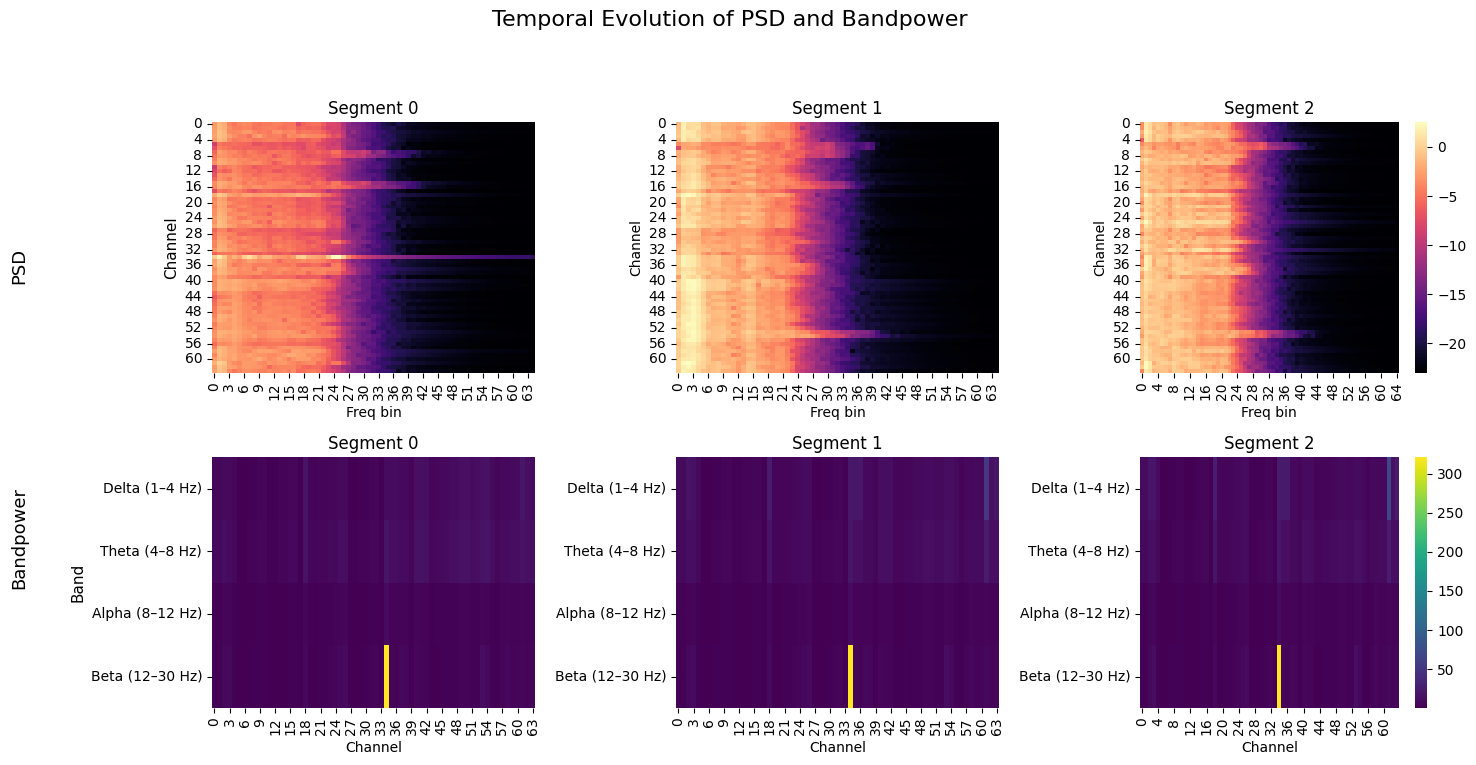

Saved combined figure: /kaggle/working/output6/psd_bandpower_evolution/temporal_evolution_psd_bandpower_segments_0_1_2.png


In [75]:
segments_to_show = [0, 1, 2]

plot_temporal_evolution_psd_bp(
    psd_seq=psd_seq,
    bp_seq=bp_seq,
    seg_indices=segments_to_show,
    filename_prefix="temporal_evolution_psd_bandpower"
)


In [77]:
/kaggle/working/output6/psd_bandpower_evolution/temporal_evolution_psd_bandpower_segments_0_1_2.png


NameError: name 'kaggle' is not defined

Alcoholic bandpower values: (729600,)
Control bandpower values: (726528,)


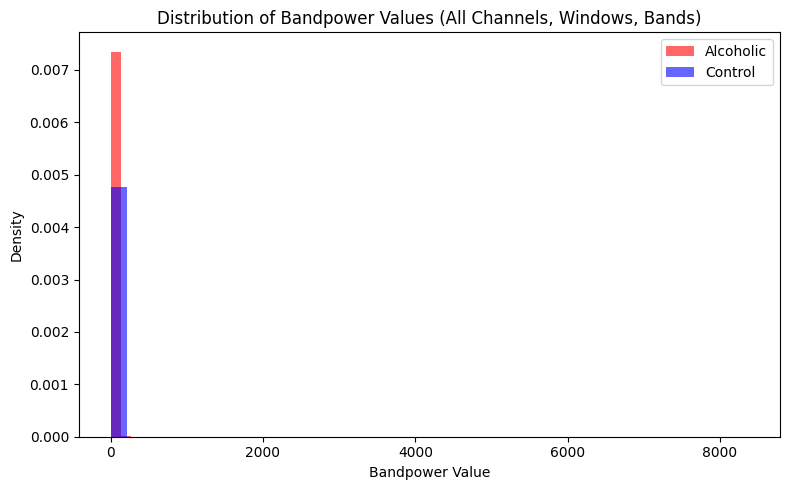

In [78]:
import numpy as np
import matplotlib.pyplot as plt

# X_features: (num_samples, num_windows, 8*8*4)
num_samples, num_windows, flat_dim = X_features.shape
height = width = 8
num_bands = 4

# reshape to: (samples, windows, channels, bands)
bp = X_features.reshape(num_samples, num_windows, height*width, num_bands)  # (N, W, 64, 4)

# choose which band(s) to use for the distribution
# e.g. use all bands:
bp_all = bp  # (N, W, 64, 4)

# split by class (y: 0=control, 1=alcoholic)
alcoholic_bp = bp_all[y == 1].ravel()
control_bp   = bp_all[y == 0].ravel()

print("Alcoholic bandpower values:", alcoholic_bp.shape)
print("Control bandpower values:", control_bp.shape)

plt.figure(figsize=(8, 5))
plt.hist(alcoholic_bp, bins=40, density=True, alpha=0.6, color='red', label='Alcoholic')
plt.hist(control_bp,   bins=40, density=True, alpha=0.6, color='blue', label='Control')

plt.xlabel("Bandpower Value")
plt.ylabel("Density")
plt.title("Distribution of Bandpower Values (All Channels, Windows, Bands)")
plt.legend()
plt.tight_layout()

# save if you like
plt.savefig("/kaggle/working/bandpower_distribution.png", dpi=300)
plt.show()


In [79]:
bp_all = bp  # all bands


In [80]:
band_idx = 2   # 0:delta, 1:theta, 2:alpha, 3:beta
bp_all = bp[..., band_idx]  # (N, W, 64)


In [81]:
import numpy as np
import matplotlib.pyplot as plt

# psd_data_reduced: (num_samples, num_channels, n_freq_features)
# labels: 0=control, 1=alcoholic
N, C, F = psd_data_reduced.shape

# use all PSD values
psd_all = psd_data_reduced  # (N, C, F)

alcoholic_psd = psd_all[labels == 1].ravel()
control_psd   = psd_all[labels == 0].ravel()

print("Alcoholic PSD values:", alcoholic_psd.shape)
print("Control PSD values:", control_psd.shape)

plt.figure(figsize=(8, 5))
plt.hist(alcoholic_psd, bins=40, density=True, alpha=0.6, color='red', label='Alcoholic')
plt.hist(control_psd,   bins=40, density=True, alpha=0.6, color='blue', label='Control')

plt.xlabel("PSD Value")
plt.ylabel("Density")
plt.title("Distribution of PSD Values (All Channels & Frequency Features)")
plt.legend()
plt.tight_layout()

plt.savefig("/kaggle/working/psd_distribution.png", dpi=300)
plt.show()


IndexError: boolean index did not match indexed array along dimension 0; dimension is 948 but corresponding boolean dimension is 45

Per-sample bandpower shape: (1896, 4)


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

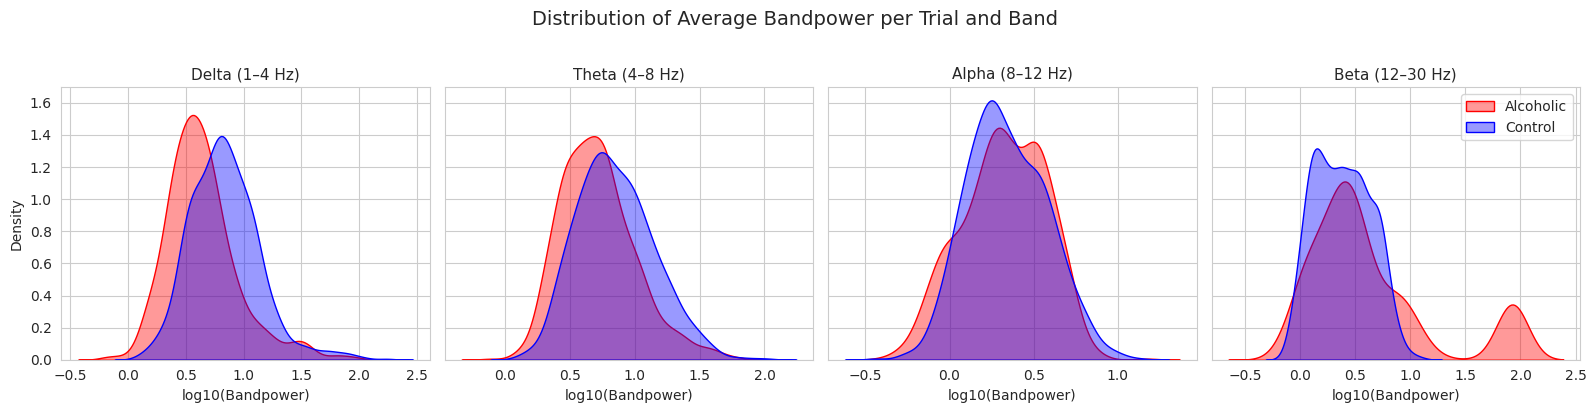

Saved bandpower distribution figure to: /kaggle/working/output6/bandpower_evolution/bandpower_distribution_per_band.png


In [82]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Where to save the figure
BP_DIST_OUTDIR = os.path.join(OUTDIR2, "bandpower_evolution")
os.makedirs(BP_DIST_OUTDIR, exist_ok=True)

band_labels = ["Delta (1–4 Hz)", "Theta (4–8 Hz)",
               "Alpha (8–12 Hz)", "Beta (12–30 Hz)"]

# X_features: (num_samples, num_windows, 8*8*4)
num_samples, num_windows, flat_dim = X_features.shape
height = width = 8
num_bands = 4
num_channels = height * width  # 64

# Reshape to (N, W, 64, 4)
bp = X_features.reshape(num_samples, num_windows, num_channels, num_bands)

# ---- 1) Average over channels and windows → per-trial bandpower ----
# result: (num_samples, 4)
bp_per_sample_band = bp.mean(axis=(1, 2))

# Split by class (you already use y: 0 = control, 1 = alcoholic)
bp_alc  = bp_per_sample_band[y == 1]   # (N_alc, 4)
bp_ctrl = bp_per_sample_band[y == 0]   # (N_ctrl, 4)

print("Per-sample bandpower shape:", bp_per_sample_band.shape)

# ---- 2) Plot distributions per band ----
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, num_bands, figsize=(16, 4), sharey=True)

for b in range(num_bands):
    ax = axes[b]

    # Optional: log-transform to reduce skew
    alc_vals  = np.log10(bp_alc[:, b] + 1e-8)
    ctrl_vals = np.log10(bp_ctrl[:, b] + 1e-8)

    # Smooth density curves (KDE) + light hist, journal-style
    sns.kdeplot(alc_vals,  ax=ax, fill=True, alpha=0.4, color="red",  label="Alcoholic")
    sns.kdeplot(ctrl_vals, ax=ax, fill=True, alpha=0.4, color="blue", label="Control")

    ax.set_title(band_labels[b], fontsize=11)
    ax.set_xlabel("log10(Bandpower)")
    if b == 0:
        ax.set_ylabel("Density")

    # Make it cleaner
    ax.legend().set_visible(b == num_bands - 1)  # show legend only on last subplot

fig.suptitle("Distribution of Average Bandpower per Trial and Band", fontsize=14, y=1.02)
plt.tight_layout()

bp_dist_path = os.path.join(BP_DIST_OUTDIR, "bandpower_distribution_per_band.png")
plt.savefig(bp_dist_path, dpi=300, bbox_inches="tight")
plt.show()

print("Saved bandpower distribution figure to:", bp_dist_path)


Per-sample bandpower shape: (1896, 4)


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

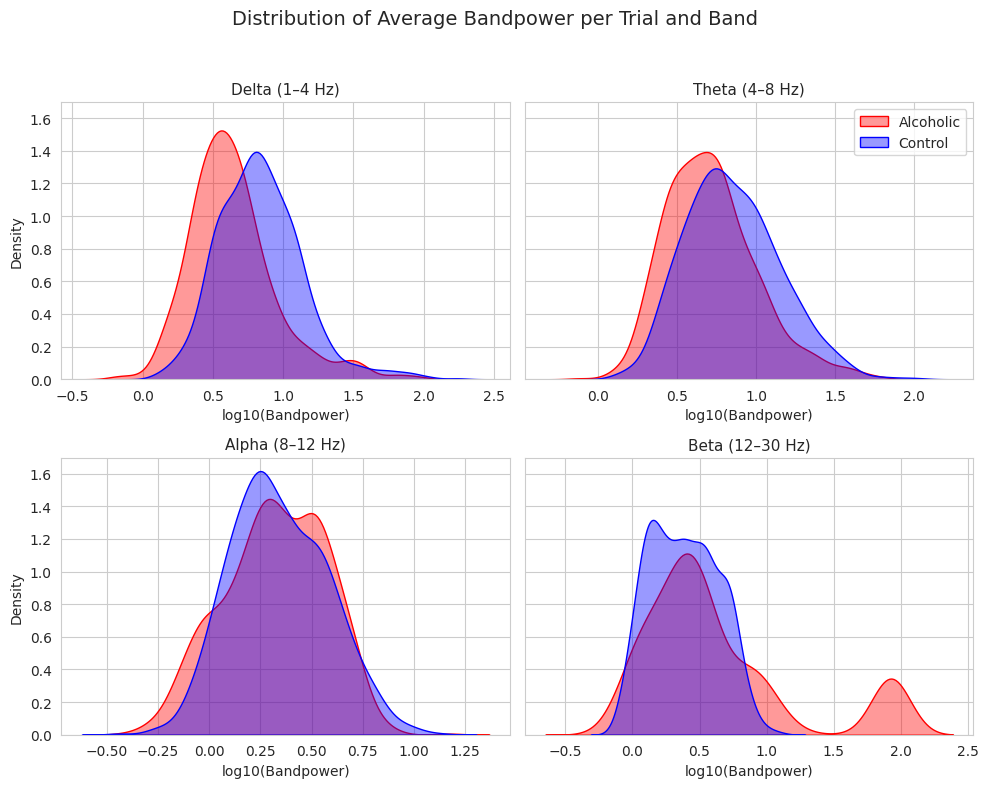

Saved merged 4-band figure to: /kaggle/working/output6/bandpower_evolution/bandpower_distribution_2x2.png


In [83]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Where to save the merged figure
BP_DIST_OUTDIR = os.path.join(OUTDIR2, "bandpower_evolution")
os.makedirs(BP_DIST_OUTDIR, exist_ok=True)

band_labels = ["Delta (1–4 Hz)", "Theta (4–8 Hz)",
               "Alpha (8–12 Hz)", "Beta (12–30 Hz)"]

# X_features: (num_samples, num_windows, 8*8*4)
num_samples, num_windows, flat_dim = X_features.shape
height = width = 8
num_bands = 4
num_channels = height * width  # 64

# Reshape to (N, W, 64, 4)
bp = X_features.reshape(num_samples, num_windows, num_channels, num_bands)

# ---- Average over channels and windows → per-trial bandpower (N, 4) ----
bp_per_sample_band = bp.mean(axis=(1, 2))

# Split by class
bp_alc  = bp_per_sample_band[y == 1]   # alcoholic
bp_ctrl = bp_per_sample_band[y == 0]   # control

print("Per-sample bandpower shape:", bp_per_sample_band.shape)

# ---- 2×2 figure for all four bands ----
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharey=True)
axes = axes.ravel()

for b in range(num_bands):
    ax = axes[b]

    # log-transform to control skew
    alc_vals  = np.log10(bp_alc[:, b] + 1e-8)
    ctrl_vals = np.log10(bp_ctrl[:, b] + 1e-8)

    sns.kdeplot(alc_vals,  ax=ax, fill=True, alpha=0.4, color="red",  label="Alcoholic")
    sns.kdeplot(ctrl_vals, ax=ax, fill=True, alpha=0.4, color="blue", label="Control")

    ax.set_title(band_labels[b], fontsize=11)
    ax.set_xlabel("log10(Bandpower)")
    if b in [0, 2]:
        ax.set_ylabel("Density")

# show legend only once
axes[1].legend(loc="upper right")

fig.suptitle("Distribution of Average Bandpower per Trial and Band", fontsize=14, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.95])

bp_dist_path = os.path.join(BP_DIST_OUTDIR, "bandpower_distribution_2x2.png")
plt.savefig(bp_dist_path, dpi=300, bbox_inches="tight")
plt.show()

print("Saved merged 4-band figure to:", bp_dist_path)


Per-sample bandpower shape: (1896, 4)


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

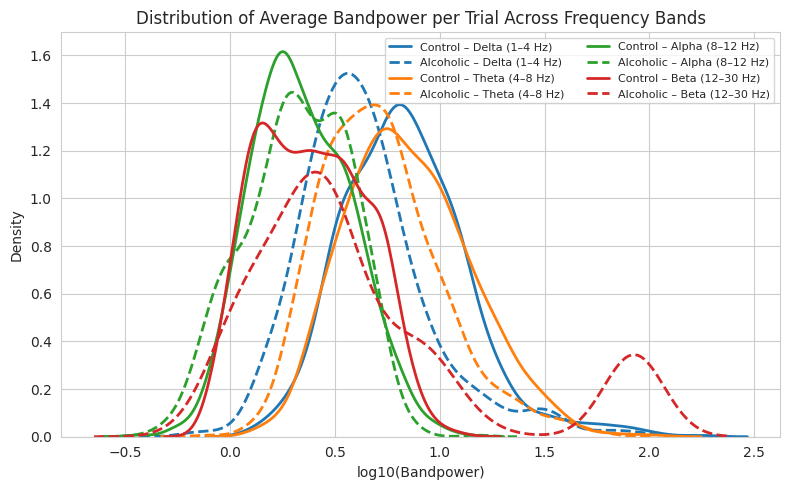

Saved single-figure bandpower distribution to: /kaggle/working/output6/bandpower_evolution/bandpower_distribution_all_bands_single_axis.png


In [84]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Where to save the figure
BP_DIST_OUTDIR = os.path.join(OUTDIR2, "bandpower_evolution")
os.makedirs(BP_DIST_OUTDIR, exist_ok=True)

band_labels = ["Delta (1–4 Hz)", "Theta (4–8 Hz)",
               "Alpha (8–12 Hz)", "Beta (12–30 Hz)"]

# ---------- prepare per-trial bandpower (same as before) ----------
# X_features: (num_samples, num_windows, 8*8*4)
num_samples, num_windows, flat_dim = X_features.shape
height = width = 8
num_bands = 4
num_channels = height * width  # 64

# Reshape to (N, W, 64, 4)
bp = X_features.reshape(num_samples, num_windows, num_channels, num_bands)

# Average over channels and windows → per-trial bandpower (N, 4)
bp_per_sample_band = bp.mean(axis=(1, 2))   # shape: (N, 4)

# Split by class (y: 0 = control, 1 = alcoholic)
bp_alc  = bp_per_sample_band[y == 1]   # (N_alc, 4)
bp_ctrl = bp_per_sample_band[y == 0]   # (N_ctrl, 4)

print("Per-sample bandpower shape:", bp_per_sample_band.shape)

# ---------- single-axis figure with all bands ----------
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]

for b in range(num_bands):
    # log-transform to reduce skew
    alc_vals  = np.log10(bp_alc[:, b]  + 1e-8)
    ctrl_vals = np.log10(bp_ctrl[:, b] + 1e-8)

    # Control: solid line
    sns.kdeplot(
        ctrl_vals, fill=False, color=colors[b],
        linestyle="-", linewidth=2,
        label=f"Control – {band_labels[b]}"
    )

    # Alcoholic: dashed line
    sns.kdeplot(
        alc_vals, fill=False, color=colors[b],
        linestyle="--", linewidth=2,
        label=f"Alcoholic – {band_labels[b]}"
    )

plt.xlabel("log10(Bandpower)")
plt.ylabel("Density")
plt.title("Distribution of Average Bandpower per Trial Across Frequency Bands")
plt.legend(fontsize=8, ncol=2)
plt.tight_layout()

bp_single_path = os.path.join(BP_DIST_OUTDIR, "bandpower_distribution_all_bands_single_axis.png")
plt.savefig(bp_single_path, dpi=300, bbox_inches="tight")
plt.show()

print("Saved single-figure bandpower distribution to:", bp_single_path)


Per-sample bandpower shape: (1896, 4)


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

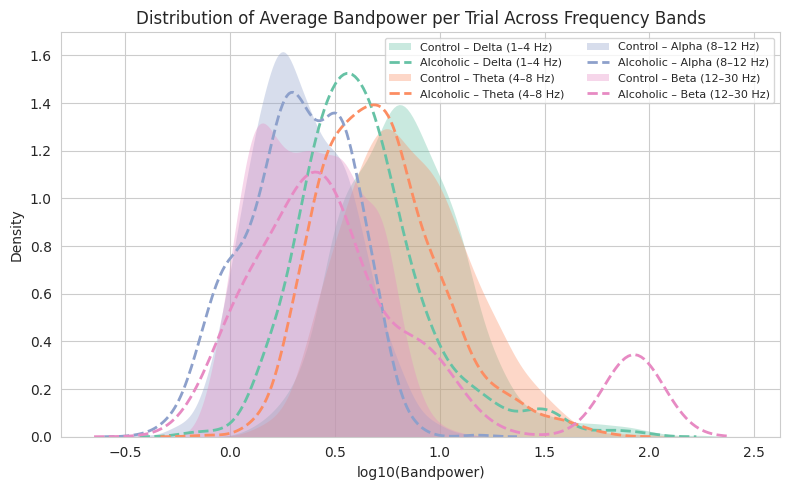

Saved colorful bandpower distribution to: /kaggle/working/output6/bandpower_evolution/bandpower_distribution_all_bands_single_axis_colorful.png


In [85]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Where to save the figure
BP_DIST_OUTDIR = os.path.join(OUTDIR2, "bandpower_evolution")
os.makedirs(BP_DIST_OUTDIR, exist_ok=True)

band_labels = ["Delta (1–4 Hz)", "Theta (4–8 Hz)",
               "Alpha (8–12 Hz)", "Beta (12–30 Hz)"]

# ---------- prepare per-trial bandpower ----------
# X_features: (num_samples, num_windows, 8*8*4)
num_samples, num_windows, flat_dim = X_features.shape
height = width = 8
num_bands = 4
num_channels = height * width  # 64

# Reshape to (N, W, 64, 4)
bp = X_features.reshape(num_samples, num_windows, num_channels, num_bands)

# Average over channels and windows → per-trial bandpower (N, 4)
bp_per_sample_band = bp.mean(axis=(1, 2))   # shape: (N, 4)

# Split by class (y: 0 = control, 1 = alcoholic)
bp_alc  = bp_per_sample_band[y == 1]   # (N_alc, 4)
bp_ctrl = bp_per_sample_band[y == 0]   # (N_ctrl, 4)

print("Per-sample bandpower shape:", bp_per_sample_band.shape)

# ---------- nice colorful single-axis figure ----------
sns.set_style("whitegrid")

plt.figure(figsize=(8, 5))

# pick a bright palette: 4 distinct colors (one per band)
palette = sns.color_palette("Set2", n_colors=num_bands)

for b in range(num_bands):
    base_color = palette[b]

    # log-transform to reduce skew
    alc_vals  = np.log10(bp_alc[:, b]  + 1e-8)
    ctrl_vals = np.log10(bp_ctrl[:, b] + 1e-8)

    # Control: filled, semi-transparent
    sns.kdeplot(
        ctrl_vals,
        fill=True,
        alpha=0.35,
        color=base_color,
        linewidth=0,
        label=f"Control – {band_labels[b]}"
    )

    # Alcoholic: same color, solid outline on top
    sns.kdeplot(
        alc_vals,
        fill=False,
        color=base_color,
        linewidth=2,
        linestyle="--",
        label=f"Alcoholic – {band_labels[b]}"
    )

plt.xlabel("log10(Bandpower)")
plt.ylabel("Density")
plt.title("Distribution of Average Bandpower per Trial Across Frequency Bands")
plt.legend(fontsize=8, ncol=2, frameon=True)
plt.tight_layout()

bp_single_path = os.path.join(
    BP_DIST_OUTDIR,
    "bandpower_distribution_all_bands_single_axis_colorful.png"
)
plt.savefig(bp_single_path, dpi=300, bbox_inches="tight")
plt.show()

print("Saved colorful bandpower distribution to:", bp_single_path)


In [86]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------- Directory to save the PSD figure ----------------
PSD_DIST_OUTDIR = "/kaggle/working/psd_distribution"
os.makedirs(PSD_DIST_OUTDIR, exist_ok=True)

# psd_data_reduced: (num_samples, num_channels, n_psd_features)
# labels: 0 = control, 1 = alcoholic
N, C, F = psd_data_reduced.shape
print("psd_data_reduced shape:", psd_data_reduced.shape)

# 1) Average across channels and PSD features -> one value per trial
psd_per_sample = psd_data_reduced.mean(axis=(1, 2))   # shape: (N,)
print("Per-sample PSD shape:", psd_per_sample.shape)

# 2) Split into Alcoholic vs Control
psd_alc  = psd_per_sample[labels == 1]
psd_ctrl = psd_per_sample[labels == 0]

print("Alcoholic PSD values:", psd_alc.shape)
print("Control PSD values:", psd_ctrl.shape)

# 3) Colorful single-axis KDE plot
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))

base_color = sns.color_palette("Set1", n_colors=1)[0]

# optional: log-transform if distribution is skewed
alc_vals  = np.log10(psd_alc  + 1e-8)
ctrl_vals = np.log10(psd_ctrl + 1e-8)

# Control: filled
sns.kdeplot(
    ctrl_vals,
    fill=True,
    alpha=0.35,
    color=base_color,
    linewidth=0,
    label="Control – PSD"
)

# Alcoholic: dashed outline, same color
sns.kdeplot(
    alc_vals,
    fill=False,
    color=base_color,
    linewidth=2,
    linestyle="--",
    label="Alcoholic – PSD"
)

plt.xlabel("log10(PSD Feature Value)")
plt.ylabel("Density")
plt.title("Distribution of Average PSD Feature per Trial")
plt.legend(fontsize=9, frameon=True)
plt.tight_layout()

psd_single_path = os.path.join(
    PSD_DIST_OUTDIR,
    "psd_distribution_single_axis_colorful.png"
)
plt.savefig(psd_single_path, dpi=300, bbox_inches="tight")
plt.show()

print("Saved colorful PSD distribution to:", psd_single_path)


psd_data_reduced shape: (948, 64, 20)
Per-sample PSD shape: (948,)


IndexError: boolean index did not match indexed array along dimension 0; dimension is 948 but corresponding boolean dimension is 45

labels_psd shape: (948,)
psd_data_reduced shape: (948, 64, 20)
Per-sample PSD shape: (948,)
Alcoholic PSD values: (475,)
Control PSD values: (473,)


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


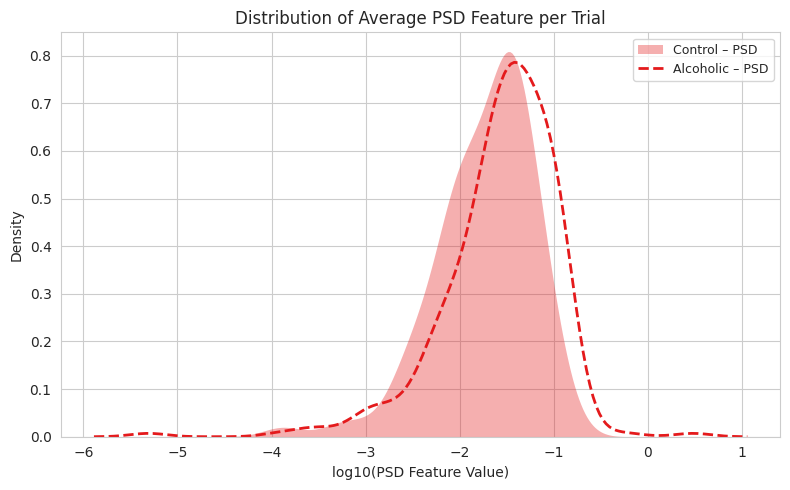

Saved colorful PSD distribution to: /kaggle/working/psd_distribution/psd_distribution_single_axis_colorful.png


In [87]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------- Directory to save the PSD figure ----------------
PSD_DIST_OUTDIR = "/kaggle/working/psd_distribution"
os.makedirs(PSD_DIST_OUTDIR, exist_ok=True)

# Make sure we're using the labels that match psd_data_reduced
# (from the same combined_data_new2.dat file)
labels_psd = data_dict['labels']          # <-- important
labels_psd = np.asarray(labels_psd)

print("labels_psd shape:", labels_psd.shape)
print("psd_data_reduced shape:", psd_data_reduced.shape)

# Sanity check: lengths must match
if labels_psd.shape[0] != psd_data_reduced.shape[0]:
    raise ValueError(
        f"Label length {labels_psd.shape[0]} does not match PSD samples {psd_data_reduced.shape[0]}"
    )

# psd_data_reduced: (num_samples, num_channels, n_psd_features)
N, C, F = psd_data_reduced.shape

# 1) Average across channels and PSD features -> one value per trial
psd_per_sample = psd_data_reduced.mean(axis=(1, 2))   # shape: (N,)
print("Per-sample PSD shape:", psd_per_sample.shape)

# 2) Split into Alcoholic vs Control using the correct labels
psd_alc  = psd_per_sample[labels_psd == 1]
psd_ctrl = psd_per_sample[labels_psd == 0]

print("Alcoholic PSD values:", psd_alc.shape)
print("Control PSD values:", psd_ctrl.shape)

# 3) Colorful single-axis KDE plot (matching the bandpower style)
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))

base_color = sns.color_palette("Set1", n_colors=1)[0]

# optional: log-transform if distribution is skewed
alc_vals  = np.log10(psd_alc  + 1e-8)
ctrl_vals = np.log10(psd_ctrl + 1e-8)

# Control: filled
sns.kdeplot(
    ctrl_vals,
    fill=True,
    alpha=0.35,
    color=base_color,
    linewidth=0,
    label="Control – PSD"
)

# Alcoholic: dashed outline, same color
sns.kdeplot(
    alc_vals,
    fill=False,
    color=base_color,
    linewidth=2,
    linestyle="--",
    label="Alcoholic – PSD"
)

plt.xlabel("log10(PSD Feature Value)")
plt.ylabel("Density")
plt.title("Distribution of Average PSD Feature per Trial")
plt.legend(fontsize=9, frameon=True)
plt.tight_layout()

psd_single_path = os.path.join(
    PSD_DIST_OUTDIR,
    "psd_distribution_single_axis_colorful.png"
)
plt.savefig(psd_single_path, dpi=300, bbox_inches="tight")
plt.show()

print("Saved colorful PSD distribution to:", psd_single_path)
